In [53]:
# This block is for initialiizing our language model
# Specifically we're using Phi4 because it doesn't need tools for summarization
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="qwen2.5:14b",
    temperature=0,
    # other params...
)

# This block will load some documents from the web
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [54]:
# Imports
from langchain_community.document_loaders import JSONLoader
import os

# Path to your JSON file
file_path = os.path.expanduser('~/data/ChatGptData/conversations_simplified.json')

# Define the jq query to extract titles, date/time, and messages
jq_query = '''
.[] | {title: .title, create_time: .create_time, messages: .messages} | tostring
'''

# Initialize the JSON loader
loader = JSONLoader(file_path, jq_query)

# Load the documents
docs = loader.load()

print(docs[0])

page_content='{"title":"Refining ChatGPT Responses","create_time":1738451416.237125,"messages":"user: Trying to build a better model of myself for a questionaire as well as to feed you: Here are the questions that the ChatGPT app requires: \n\nWhat should ChatGPT call you?\r\n\r\n\nWhat do you do?\r\n\r\n\nWhat traits should ChatGPT have?\r\n\r\n \n\r\n\r\n\r\nAnything else ChatGPT should know about you?\n\nHow should I best answer these questions to get the best responses\nChatGPT: Since you're trying to refine how I understand and respond to you, you should answer these questions with a mix of specificity and flexibility—clear enough that I can tailor responses, but open-ended enough that you're not boxed in. Here's how you might answer based on what I already know, with some room for improvement:\n\n### 1. **What should ChatGPT call you?**  \nUse something simple but memorable. You could go with your name, a nickname, or something thematic. If you want responses to feel more persona

In [55]:
from langchain_core.prompts import ChatPromptTemplate

# Define the map prompt
map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Define the reduce prompt
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes.
Try to understand the general goals of the various conversations and how they relate to each other.
Further, try to understand the general goals of the user and how they relate to the various conversations.
Build a model of the user based on the conversations.
"""
reduce_prompt = ChatPromptTemplate.from_messages([("human", reduce_template)])

In [56]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 617 documents.


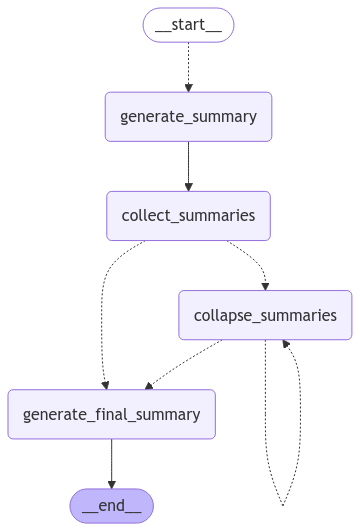

In [57]:
from enum import Enum
import json
import logging
import operator
import asyncio
import aiofiles
import time
from typing import Annotated, List, Literal, TypedDict
from datetime import datetime
from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 2000
SUMMARY_FILE = '~/data/ChatGptData/summaries.json'

def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    tokens = [llm.get_num_tokens(doc.page_content) for doc in documents]
    token_sum = sum(tokens)
    print(f"Token sum: {token_sum}")
    print(f"Token average: {token_sum/len(tokens)}")
    return token_sum

def load_state(file_path: str) -> dict:
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        return {}
    
def save_state(file_path: str, state: dict):
    with open(file_path, 'w') as file:
        json.dump(state, file, indent=4)

def extract_create_time(document_str: str) -> float:
    document_dict = json.loads(document_str)
    return float(document_dict.get("create_time", ""))

def get_document_id(document_str: str) -> str:
    try:
        doc_time = extract_create_time(document_str)
    except json.JSONDecodeError:
        doc_time = datetime.now().timestamp()
    return str(doc_time)

class SummaryStatus(Enum):
    NOT_PROCESSED = 1
    PROCESSING = 2
    PROCESSED = 3
    PROCESSING_FAILED = 4

# This will be the state of each individual document
class SummaryState(TypedDict):
    content: str
'''
class SummaryState():
    def __init__(self, content, state_file):
        self.content: str = content
        self.state_file: str = state_file
        self.doc_id: str = get_document_id(content)
        self.status: SummaryStatus = SummaryStatus.NOT_PROCESSED
        self.summary: str = ""
    
    async def summarize_content(self):
        try:
            self.status = SummaryStatus.PROCESSING
            prompt = map_prompt.invoke(self.content)
            response = await llm.ainvoke(prompt)
            self.summary = response.content
            self.status = SummaryStatus.PROCESSED
            logging.info(f"Document {self.doc_id} processed successfully.")
        except Exception as e:
            self.summary = ""
            self.status = SummaryStatus.PROCESSING_FAILED
            logging.error(f"Error processing document {self.doc_id}: {e}")

    def save_summary_state(self):
        logging.debug(f"Saving state for document {self.doc_id}.")
        state = load_state(self.state_file)
        state['summaries'][self.doc_id] = self
        save_state(self.state_file, state)
        logging.info(f"State for document {self.doc_id} saved successfully.")
'''
# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str
'''
class OverallState(TypedDict):
    state_file: str = ""
    contents: List[str] = ""
    summaries: Dict[str, SummaryState]  # Dictionary to store SummaryState objects
    collapsed_summaries: List[Document]
    final_summary: str
'''
def load_summaries(summary_file: str = SUMMARY_FILE) -> dict:
    """Load saved summaries and return processed doc IDs and summary data."""
    summaries = {}

    filename = os.path.expanduser(summary_file)  # Expand '~' to full path
    if not os.path.exists(filename):
        return summaries
    
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            try:
                summary = json.loads(line.strip())  # Convert JSON string to dict
                summaries[summary["doc_id"]] = summary  # Store it in a dictionary
            except json.JSONDecodeError:
                logging.warning(f"Failed to decode JSON: {line.strip()}")
    
    return summaries
 
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

SEMAPHORE = asyncio.Semaphore(10)  # Change 10 to tune concurrency
active_workers = 0  # Track active tasks
completed_tasks = 0  # Track completed tasks
lock = asyncio.Lock()  # Ensure thread-safe updates to counters

summary_lock = asyncio.Lock()  # Prevent simultaneous writes

async def save_summary_entry(summary: dict, summary_file=SUMMARY_FILE):
    """Append a summary entry to a JSON file asynchronously, ensuring safety."""
    if "doc_id" not in summary:
        raise ValueError("Missing required 'doc_id' field in summary.")

    filename = os.path.expanduser(summary_file)  # Expand '~' to full path
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure directory exists

    try:
        async with summary_lock:
            async with aiofiles.open(filename, "a", encoding="utf-8") as f:
                await f.write(json.dumps(summary, ensure_ascii=False) + "\n")

        logging.info(f"Saved summary for {summary['doc_id']}.")

    except Exception as e:
        logging.exception(f"Error saving summary {summary['doc_id']}: {e}")
        raise

async def generate_summary(state):
    """Generates a summary for a single document while tracking performance."""
    global active_workers, completed_tasks

    async with SEMAPHORE:
        start_time = time.time()  # Track execution time

        async with lock:  # Safely update active worker count
            active_workers += 1
            logging.info(f"Task started. Active workers: {active_workers}")

        try:
            prompt = map_prompt.invoke(state["content"])
            response = await asyncio.wait_for(llm.ainvoke(prompt), timeout=240)  # 4-minute timeout
            summary = response.content
            status = SummaryStatus.PROCESSED
        except asyncio.TimeoutError:
            logging.warning(f"Timeout: Document {state['content']} took too long.")
            summary = ""
            status = SummaryStatus.PROCESSING_FAILED
        except Exception as e:
            logging.error(f"Error processing document {state['content']}: {e}")
            summary = ""
            status = SummaryStatus.PROCESSING_FAILED
        finally:
            execution_time = time.time() - start_time  # Calculate execution time

            async with lock:  # Safely update worker and completed task counts
                active_workers -= 1
                completed_tasks += 1
                logging.info(f"Task finished in {execution_time:.2f}s. "
                             f"Active workers: {active_workers}, Completed tasks: {completed_tasks}"
                             f"Summary: {summary[:50]}...")
                
    # Save the summary entry to a file
    summary_entry = {
        "doc_id": get_document_id(state["content"]),
        "summary": summary,
        "status": status.name,
        "execution_time": round(execution_time, 2),
        "timestamp": datetime.now().isoformat() + "Z",
    }

    await save_summary_entry(summary_entry)

    return {"summaries": [summary]}

'''
async def generate_summary(summary_state: SummaryState):
    summary_state.summarize_content()
    #summary_state.save_summary_state()
    # We return the whole updated document summary object nested into the overall state
    print(summary_state.summary[:50])
    return {"summaries": [summary_state.summary]}
'''

def map_summaries(state: OverallState):
    """Maps documents in state['contents'] to a list of Send tasks, skipping processed ones."""

    # Sort contents by document ID for consistent processing order
    state['contents'].sort(key=lambda content: float(get_document_id(content)))

    print("Mapping summaries...")
    summarized = load_summaries(SUMMARY_FILE)
    print(f"Loaded {len(summarized)} previous summaries.")

    # Extract processed document IDs and their summaries
    processed_docs = {doc['doc_id'] for doc in summarized.values() if doc['status'] == SummaryStatus.PROCESSED.name}
    state['summaries'] += [doc['summary'] for doc in summarized.values() if doc['status'] == SummaryStatus.PROCESSED.name]
    print(f"Loaded {len(state['summaries'])} previous summaries into State Summary object type: {type(state['summaries'])}.")

    print(f"Skipping {len(processed_docs)} already processed documents.")
    print("Sending generate_summary requests...")

    return [
        Send("generate_summary", {"content": content})
        for content in state["contents"]
        if get_document_id(content) not in processed_docs
    ]

def collect_summaries(state: OverallState):
    logging.info(f"Collecting {len(state['summaries'])} summaries")
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }

async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content

# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}

# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"

# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}

# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [58]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 650},
):
    print(list(step.keys()))

2025-02-05 23:31:38,634 - INFO - Task started. Active workers: 1
2025-02-05 23:31:38,636 - INFO - Task started. Active workers: 2
2025-02-05 23:31:38,637 - INFO - Task started. Active workers: 3
2025-02-05 23:31:38,638 - INFO - Task started. Active workers: 4
2025-02-05 23:31:38,638 - INFO - Task started. Active workers: 5
2025-02-05 23:31:38,639 - INFO - Task started. Active workers: 6
2025-02-05 23:31:38,640 - INFO - Task started. Active workers: 7


Mapping summaries...
Loaded 617 previous summaries.
Loaded 610 previous summaries into State Summary object type: <class 'list'>.
Skipping 610 already processed documents.
Sending generate_summary requests...


2025-02-05 23:31:48,403 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,405 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,406 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,406 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,407 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,409 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,410 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:31:48,412 - ERROR - Error processing document {"title":"Backpack Marketing Bot Guide","create_time":1734586529.942741,"messages":"user: I want to learn more about certain brands more for say backpacks. How can I create a bot to search for every backpack company, sign up f

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
Token sum: 286546
Token average: 464.418152350081
['collect_summaries']
Token sum: 138
Token average: 138.0
Token sum: 377
Token average: 188.5
Token sum: 938
Token average: 312.6666666666667
Token sum: 1080
Token average: 270.0
Token sum: 1265
Token average: 253.0
Token sum: 1381
Token average: 230.16666666666666
Token sum: 2253
Token average: 321.85714285714283
Token sum: 1078
Token average: 539.0
Token sum: 1221
Token average: 407.0
Token sum: 1387
Token average: 346.75
Token sum: 1466
Token average: 293.2
Token sum: 1614
Token average: 269.0
Token sum: 1783
Token average: 254.71428571428572
Token sum: 2521
Token average: 315.125
Token sum: 850
Token average: 425.0
Token sum: 950
Token average: 316.6666666666667
Token sum: 1128
Token average: 282.0
Token sum: 1379
Token average: 275.8
Token sum: 2261
Token average: 376.8333333333333
Token

2025-02-05 23:31:59,348 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:32:26,913 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:32:48,086 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:33:13,777 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:33:37,115 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:34:02,690 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:34:27,556 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:34:47,549 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:35:10,025 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-05 23:35:45,740 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/cha

CancelledError: 

In [18]:
max_retries = 5
for attempt in range(max_retries):
    try:
        async for step in app.astream(
            {"contents": [doc.page_content for doc in split_docs]},
            {"recursion_limit": 25},
        ):
            print(list(step.keys()))
            if 'generate_summary' in step:
                print(f"Summary: {step['generate_summary']['summaries'][:50]}...")
    except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        print("Retrying...")
        if attempt == max_retries - 1:
            print("Max retries reached. Exiting.")

        

Attempt 1 failed: Must write to at least one of []
Retrying...
Attempt 2 failed: Must write to at least one of []
Retrying...
Attempt 3 failed: Must write to at least one of []
Retrying...
Attempt 4 failed: Must write to at least one of []
Retrying...
Attempt 5 failed: Must write to at least one of []
Retrying...
Max retries reached. Exiting.


In [59]:
print(step)

{'collect_summaries': {'collapsed_summaries': [Document(metadata={}, page_content='The conversation discusses potential revenue generation strategies for a hypothetical company named ChatGPT, which could include licensing its technology, offering subscription services, displaying ads, or selling data. The target customers might be enterprises, small and medium-sized businesses, individual developers, or governments/non-profits depending on the specific product offerings. When asked about the number of people needed to maintain such a platform, it was noted that this varies widely based on factors like platform complexity and available resources but could range from just a few individuals to hundreds or thousands. The AI also clarified that it cannot license itself as it is an OpenAI-trained model designed for providing information and assistance rather than engaging in business transactions.'), Document(metadata={}, page_content='**Summary:**\n\n- **NLP Startups:** Notable startups wor

In [ ]:
print(OverallState)